- Name: Jerry Hsiang Yu Chen
- Course: CISB62 Deep Learning in Business
- Instructor: Angel Martinon Hernandez

This project applies the Convolutional Neural Network on the CIFAR10 dataset to predict the category of each image. CIFAR10 dataset is one of the built-in datasets to keras that consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The types of images range from types of transportation vehicles and different types of animals. More information on the CIFAR10 dataset can be found in the link https://keras.io/api/datasets/cifar10/. This project will use the convolutional neural network architecture from student's submission of module 6 lab, and tuning hyperparameter based on learning rates from instructor's midterm example. Exploratory data analysis samples are taken from https://www.kaggle.com/code/faressayah/cifar-10-images-classification-using-cnns-88#%F0%9F%A4%96-Model-Building and https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/. 

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

#import warnings and ignore them
import warnings
warnings.filterwarnings('ignore')

import keras
from sklearn.model_selection import GridSearchCV
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
import os

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.layers import Flatten, Dropout
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend


**EDA Exploratory Data Analysis**

**Import the CIFAR10 small images classification dataset**

In [2]:
from keras.datasets import cifar10

**Load the data using (X_train, y_train), (X_valid, y_valid)**

In [3]:
(X_train, y_train), (X_valid, y_valid) = cifar10.load_data()

#### select a sample of an image

In [4]:
sample = np.random.randint( 0, X_train.shape[0])

#### Plot the sample image

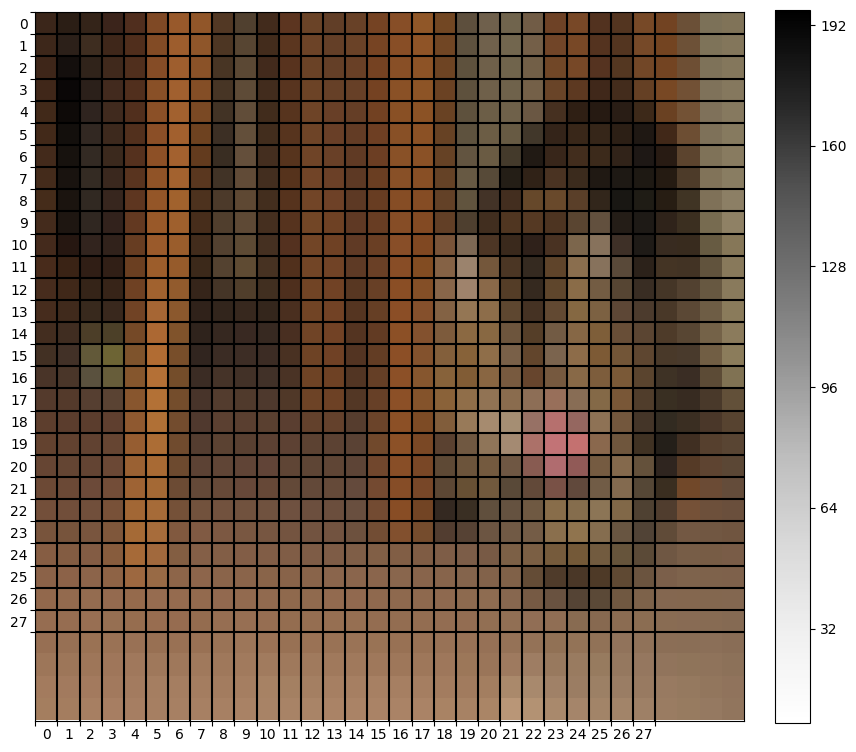

In [5]:
plt.figure(figsize = (10,10))
mnist_img = X_train[sample]
plt.imshow(mnist_img,cmap="Greys")
ax = plt.gca()

# First turn off the  major labels, but not the major ticks
plt.tick_params(
    axis='both',        # changes apply to the both x and y axes
    which='major',      # Change the major ticks only
    bottom=True,        # ticks along the bottom edge are on
    left=True,          # ticks along the top edge are on
    labelbottom=False,  # labels along the bottom edge are off
    labelleft=False)    # labels along the left edge are off

# Next turn off the minor ticks, but not the minor labels
plt.tick_params(
    axis='both',        # changes apply to both x and y axes
    which='minor',      # Change the minor ticks only
    bottom=False,       # ticks along the bottom edge are off
    left=False,         # ticks along the left edge are off
    labelbottom=True,   # labels along the bottom edge are on
    labelleft=True)     # labels along the left edge are on

# Set the major ticks, starting at 1 (the -0.5 tick gets hidden off the canvas)
ax.set_xticks(np.arange(-.5, 28, 1))
ax.set_yticks(np.arange(-.5, 28, 1))

# Set the minor ticks and labels
ax.set_xticks(np.arange(0, 28, 1), minor=True);
ax.set_xticklabels([str(i) for i in np.arange(0, 28, 1)], minor=True);
ax.set_yticks(np.arange(0, 28, 1), minor=True);
ax.set_yticklabels([str(i) for i in np.arange(0, 28, 1)], minor=True);

ax.grid(color='black', linestyle='-', linewidth=1.5)
_ = plt.colorbar(fraction=0.046, pad=0.04, ticks=[0,32,64,96,128,160,192,224,255])

In [6]:
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_valid.shape, y_valid.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


There are 50000 images in the training dataset and 10000 images in the validation dataset. The images are 32x32 pixels with 3 color channel. 

#### Rename the labels (class_names) 
#### from (0,1,2,3...,9) to
['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

#### Visualize some images showing the new label

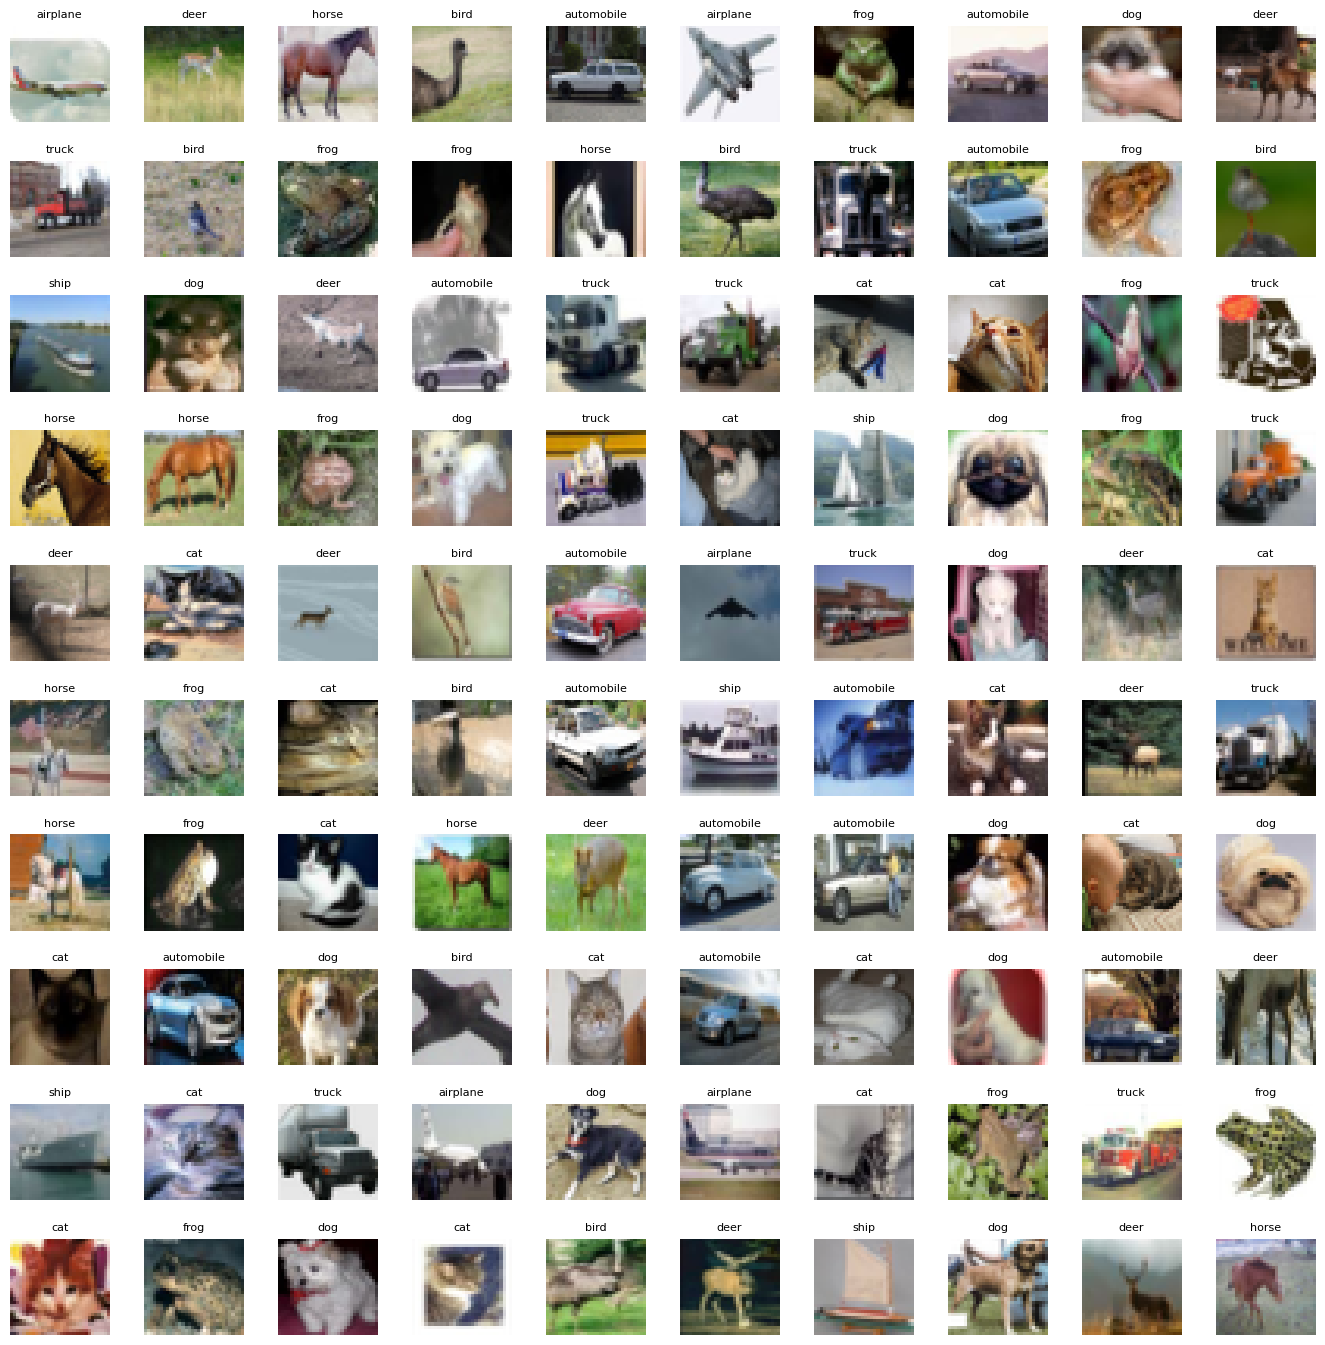

In [8]:
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(class_names[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

#### Graph the distribution of the number of each class in the training and testing data sets

Text(0.5, 1.0, 'Class distribution in training set')

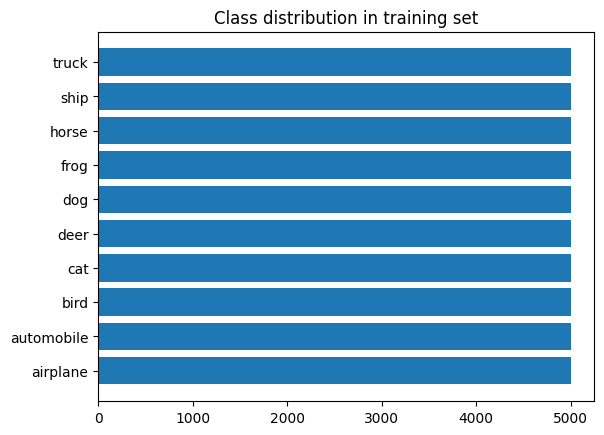

In [9]:
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(class_names,counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in validation set')

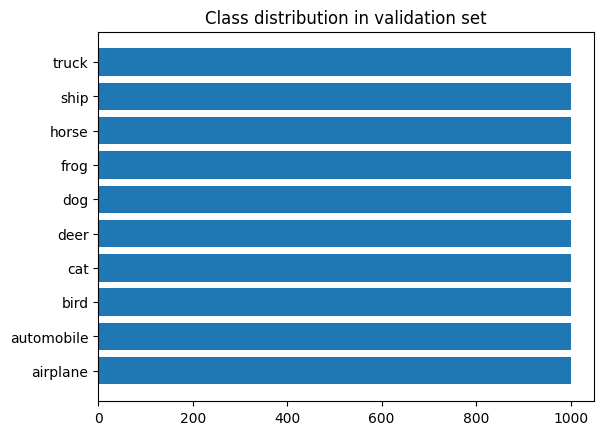

In [10]:
classes, counts = np.unique(y_valid, return_counts=True)
plt.barh(class_names,counts)
plt.title('Class distribution in validation set')

The amount of each class are evenly distributed in the training and testing dataset.

#### Preprocess the Data

- Pixel value range from no color to full color: 0 to 255. Scale the data with 255. 10 classes with unique integers: use one hot encoding to transform the integers to indexes of 1s.

In [11]:
X_valid.shape

(10000, 32, 32, 3)

In [12]:
X_train.shape

(50000, 32, 32, 3)

- Also, use the astype() method to specify the data type as ('float32') to convert the pixel darknesses from integers into single-precision float values for both X_train and X_valid.

In [13]:
X_train = X_train.reshape(50000, 32, 32, 3).astype('float32')
X_valid = X_valid.reshape(10000, 32, 32, 3).astype('float32')

### Convert the pixel intergers to floats by dividing the variables X_train and X_valid by 255.

In [14]:
X_train /= 255
X_valid /= 255

### Convert the label y (y_train,y_valid) from integers into one-hot encodings
n_classes = 10 <br> for y_train and y_valid, use tf.keras.utils.to_categorical

In [15]:
n_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)

### Design the Convolutional Neural Network architecture

- Create a Sequential model and call it "model"
- For the first convolutional layer, use the add() method with 32 filters, kernel_size of 3x3, activation relu, and the correct input shape with three parameters (32,32,3).
- For the second convolutional layer, use the add() method with 64 filters, kernel_size of 3x3, and activation relu.
- Add MaxPooling2D with a pool size of (2x2) to reduce computational complexity.
- Add dropout 30% to reduce overfitting 
- Using Flatten, convert the three dimensional activation map output by conv2D() to a one dimensional array.
- add a dense hidden layer with 128 neurons with relu activation function
- and dropout of 40% 
- add an output layer with 10 neurons, n_classes = 10, and activation function softmax

In [18]:
from keras.layers import Conv2D, MaxPooling2D # new!
#Create a Sequential model and call it "model"
model = Sequential()

#For the first convolutional layer, use the add() method with 32 filters, 
#kernel_size of 3x3, activation relu, and the correct input shape with three parameters (32,32,3)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))

#For the second convolutional layer, use the add() method with 64 filters, kernel_size of 3x3, and activation relu.
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

#Add MaxPooling2D with a pool size of (2x2) to reduce computational complexity.
model.add(MaxPooling2D(pool_size=(2, 2)))

#Add dropout 30% to reduce overfitting
model.add(Dropout(0.3))

#Using Flatten, convert the three dimensional activation map output by conv2D() to a one dimensional array.
model.add(Flatten())

#add a dense hidden layer with 128 neurons with relu activation function
#and dropout of 40%
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

#add an output layer with 10 neurons, n_classes = 10, and activation function softmax
model.add(Dense(n_classes, activation='softmax'))

### Display the summary of the model

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1605760   
                                                      

#### Compile the model with the followign parameters:
- loss="categorical_crossentropy"
- Optimizer adam
- Set the metrics to 'accuracy' to recieve feedbak on model accurancy

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the model (model.fit) with the followign parameters:
- X_train 
- y_train 
- batch_size=64
- epochs=30
- verbose=1 
- validation_data=(X_valid, y_valid))

In [21]:
model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, validation_data=(X_valid, y_valid))

Epoch 1/30
782/782 [==============================] - 20s 17ms/step - loss: 1.5053 - accuracy: 0.4605 - val_loss: 1.1192 - val_accuracy: 0.6005
Epoch 2/30
782/782 [==============================] - 13s 16ms/step - loss: 1.1344 - accuracy: 0.6006 - val_loss: 0.9818 - val_accuracy: 0.6593
Epoch 3/30
782/782 [==============================] - 13s 16ms/step - loss: 1.0038 - accuracy: 0.6460 - val_loss: 0.9429 - val_accuracy: 0.6674
Epoch 4/30
782/782 [==============================] - 13s 16ms/step - loss: 0.9174 - accuracy: 0.6772 - val_loss: 0.9038 - val_accuracy: 0.6847
Epoch 5/30
782/782 [==============================] - 13s 16ms/step - loss: 0.8495 - accuracy: 0.7009 - val_loss: 0.8911 - val_accuracy: 0.6940
Epoch 6/30
782/782 [==============================] - 13s 16ms/step - loss: 0.7940 - accuracy: 0.7183 - val_loss: 0.8671 - val_accuracy: 0.7012
Epoch 7/30
782/782 [==============================] - 13s 16ms/step - loss: 0.7426 - accuracy: 0.7335 - val_loss: 0.8717 - val_accuracy:

#### Plot the Model Loss

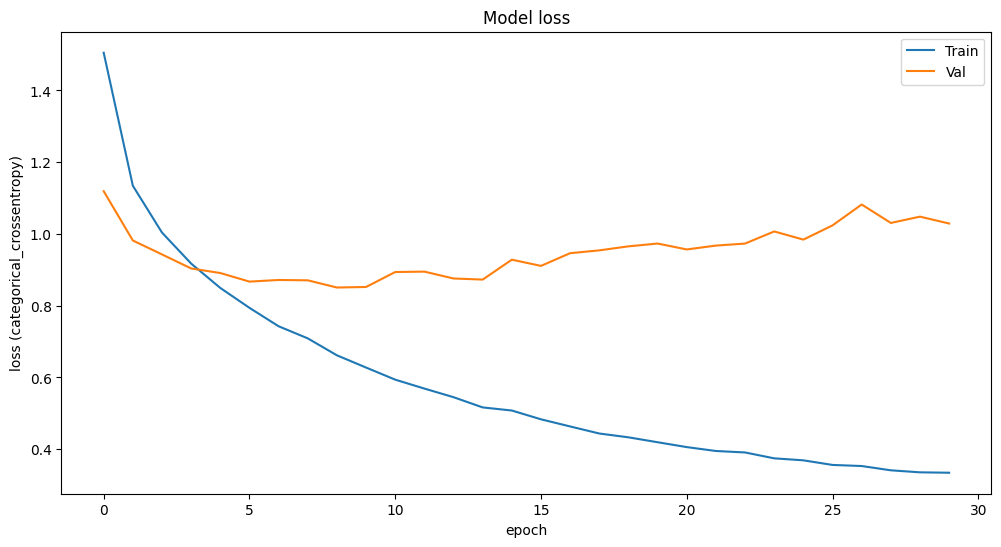

In [22]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (categorical_crossentropy)')
plt.legend(['Train', 'Val'], loc='upper right')

In [47]:
history_dict = model.history.history
print(history_dict.keys())

dict_keys([])


In [50]:
plt.figure(figsize=(12,6))

plt.plot(model.history.history['accuracy'][:])

plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train'],loc='upper right')

KeyError: 'accuracy'

<Figure size 1200x600 with 0 Axes>

#### Could not find the key value for accuracy to graph it

Signs of overfitting to the training dataset looking at the increasing loss for the validation dataset. 

### Evaluate the model (loss and accuracy)

In [23]:
loss, accuracy = model.evaluate(X_valid, y_valid)

313/313 [==============================] - 1s 3ms/step - loss: 1.0291 - accuracy: 0.7137


71% accuracy 1.0291 loss vs 88% accuracy 0.3343 loss. Model taken from module 6 lab overfits the training dataset. 

### Create a function to prin the confusion matrix
#### Feel free to use the code form your first lab, the one below, or your own code. 

In [24]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

In [25]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observacion')
    plt.xlabel('Prediccion')

313/313 [==============================] - 1s 2ms/step


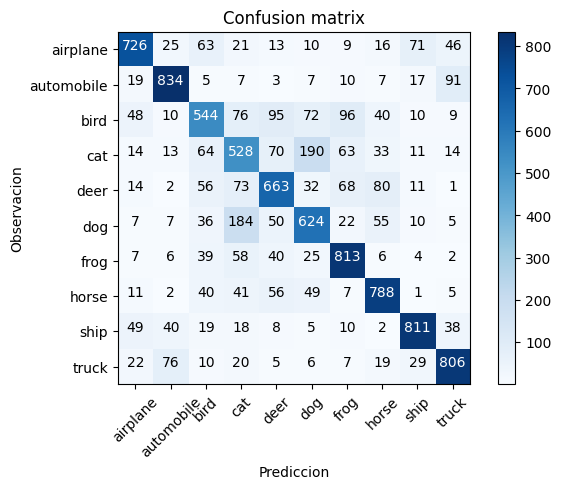

In [34]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = class_names)

Category 3 "Cat" has 528 correct predictions and 190 incorrect predictions as Category 5 "Dog". Category 5 "Dog" has 624 correct predictions and 184 incorrect predictions as Category 3 "Cat". Given the images being only 32x32 pixel, and that the model architecture is taken from module 6 used to predict monochrome clothing in the fashion_mnist dataset, I expected the same model to have difficulty distinguishing small pictures of quadrupedal creatures as cat or dog. 

#### Add a variable called predictions = model.predict(X_valid)

In [27]:
predictions = model.predict(X_valid)

313/313 [==============================] - 1s 3ms/step


#### Using X_valid, reshape, and a for loop, find out how many incorrect predictions are. Store them in a variable called: <br>incorrect_predictions = [ ]

In [30]:
images = X_valid.reshape((10000, 32, 32, 3))
incorrect_predictions = []

for i, (p, e) in enumerate(zip(predictions, y_valid)):
    predicted, expected = np.argmax(p), np.argmax(e)
    
    if predicted != expected:
        incorrect_predictions.append((i, images[i], predicted, expected))

#### Print the length of (incorrect_predictions)

In [31]:
len(incorrect_predictions)

2863

#### Plot the incorrect predictions

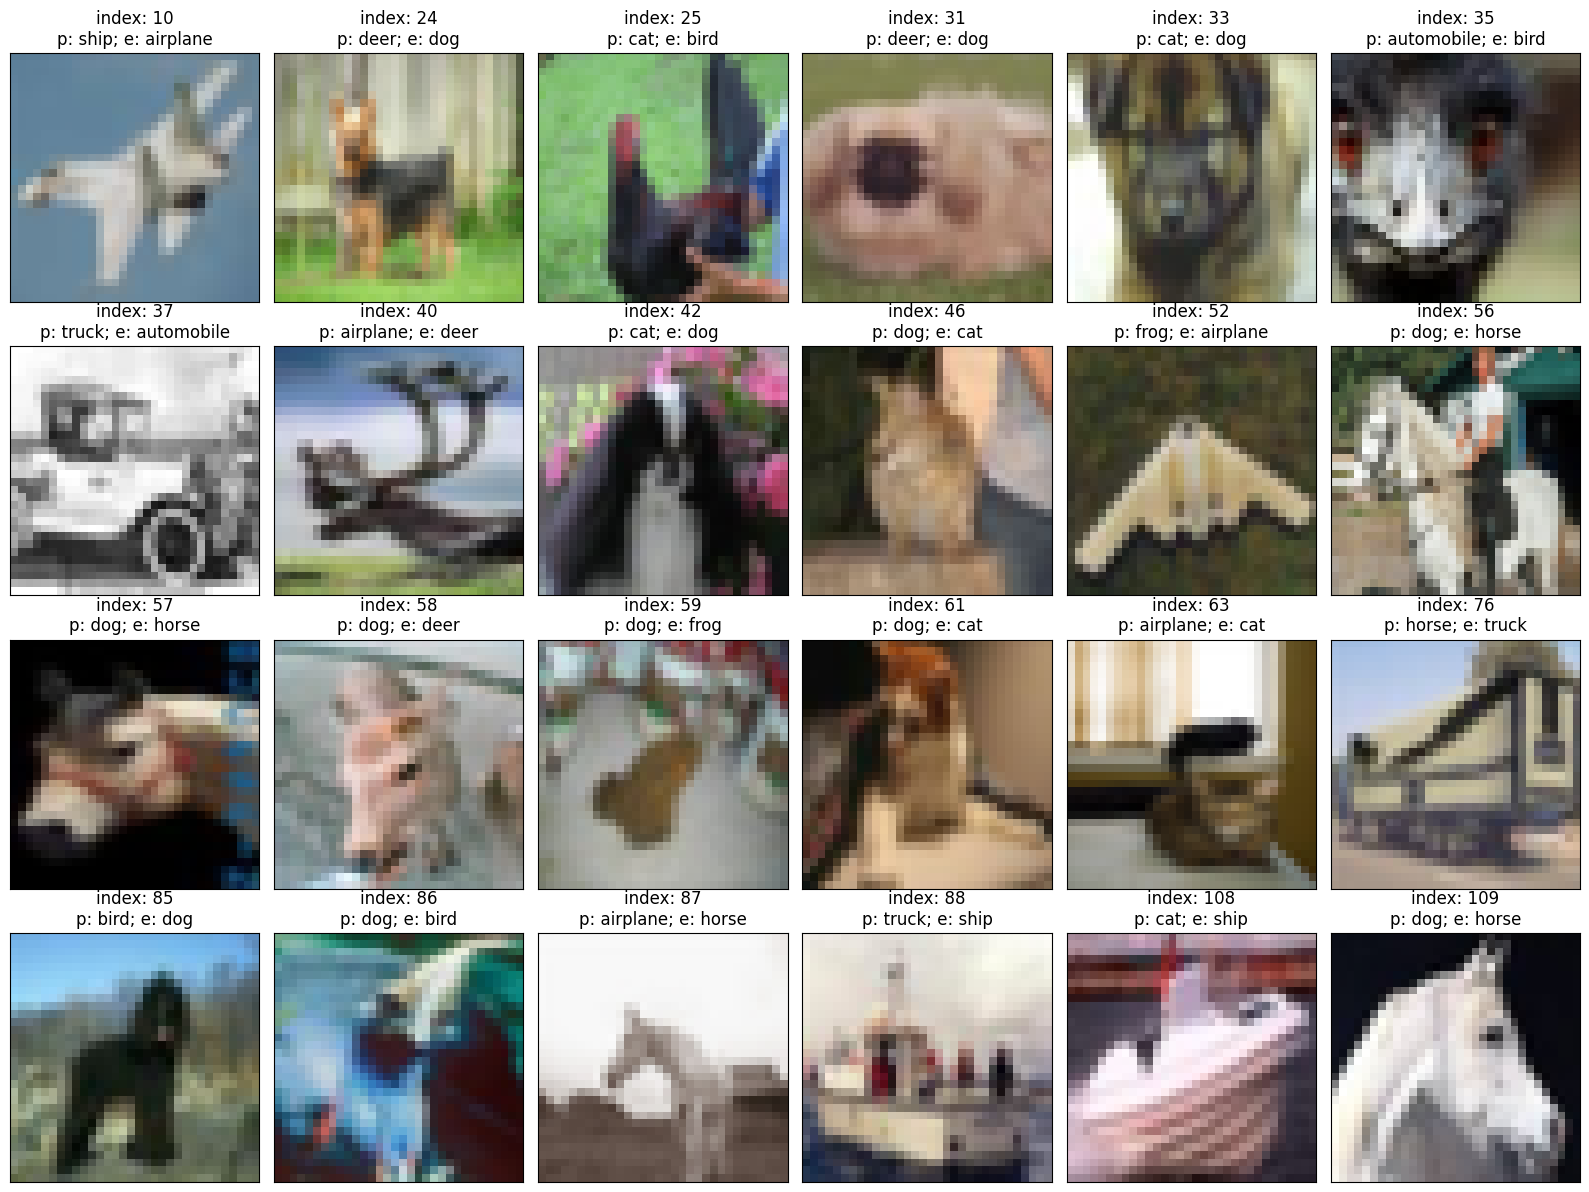

In [37]:
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])  # remove x-axis tick marks
    axes.set_yticks([])  # remove y-axis tick marks
    axes.set_title(f'index: {index}\np: {class_names[predicted]}; e: {class_names[expected]}')
plt.tight_layout()

In [52]:
from sklearn.metrics import mean_absolute_error
#display the prediction of first 5 values, then calculate mae, lastly print the first 5 predictions
#let's check how much we are off on average
#enter the three lines of code here;
y_pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid,y_pred)
y_pred[0:10]

313/313 [==============================] - 1s 2ms/step


array([[2.85442511e-05, 8.58898019e-08, 4.86242379e-06, 5.13381660e-01,
        1.68605993e-07, 4.85906601e-01, 4.73318214e-04, 1.15885028e-04,
        8.83669854e-05, 4.89764204e-07],
       [3.56677151e-03, 8.32237117e-03, 3.60594699e-14, 1.85351585e-13,
        1.35869844e-18, 1.73610287e-21, 9.28835353e-17, 6.93142715e-20,
        9.88110900e-01, 3.23572777e-08],
       [1.04077850e-02, 3.63727137e-02, 3.75919626e-07, 5.90035670e-05,
        6.35727702e-06, 2.61108045e-11, 1.00246234e-09, 3.55159315e-08,
        9.29869950e-01, 2.32837796e-02],
       [7.37653673e-01, 3.61194387e-02, 1.28351152e-04, 2.37129889e-08,
        2.98243407e-07, 4.11221190e-09, 9.17533180e-06, 2.43228868e-07,
        2.25517184e-01, 5.71499986e-04],
       [2.07814134e-16, 2.81144118e-12, 2.33788105e-05, 4.15708125e-03,
        1.86428130e-02, 2.51668837e-07, 9.77176547e-01, 2.78272440e-11,
        7.50866437e-13, 1.31363250e-13],
       [4.33728964e-12, 5.22751157e-12, 6.98794247e-06, 3.00878339e-04,
   

In [53]:
#print mae value
mae

0.06481742

In [54]:
#print the real value of record 19
y_pred[19]

array([1.7229505e-15, 1.5982414e-15, 5.7260905e-07, 6.9644315e-08,
       1.8976741e-06, 4.3623441e-13, 9.9999750e-01, 4.6328867e-14,
       1.3839741e-17, 2.1277119e-17], dtype=float32)

 Image 19 is [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
1/1 [==============================] - 0s 21ms/step
The model predict that image 19 is frog


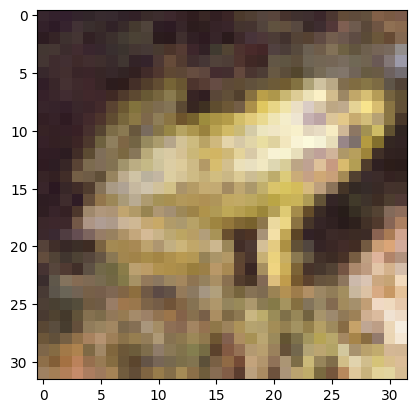

In [63]:
my_image = X_valid[19]
plt.imshow(my_image)

print(f" Image 19 is {y_valid[19]}")

pred_19 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 19 is {class_names[pred_19]}")

#### Tuning Hyper Parameters

In [83]:
#create a folder path for Hyper Parameter tuning
folder_path = "my_dir/intro_to_kt/"

In [84]:
#remove any existing log files if they exist
import shutil
folder_path = "my_dir/intro_to_kt/"
if os.path.exists(folder_path):
    #remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'my_dir/intro_to_kt/' has been deleted.


Hyper Parameter Tuning
The number of neurons in the dense layer
The learning rate is searched for the values 0.01, 0.001, or 0.0001

In [85]:
#Create a model-building function
def model_builder(hp):
    #Create a Sequential model and call it "model"
    model = Sequential()

    #For the first convolutional layer, use the add() method with 32 filters, 
    #kernel_size of 3x3, activation relu, and the correct input shape with three parameters (32,32,3)
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))

    #For the second convolutional layer, use the add() method with 64 filters, kernel_size of 3x3, and activation relu.
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

    #Add MaxPooling2D with a pool size of (2x2) to reduce computational complexity.
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Add dropout 30% to reduce overfitting
    model.add(Dropout(0.3))

    #Using Flatten, convert the three dimensional activation map output by conv2D() to a one dimensional array.
    model.add(Flatten())

    #add a dense hidden layer with 128 neurons with relu activation function
    #and dropout of 40%
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))

    #add an output layer with 10 neurons, n_classes = 10, and activation function softmax
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(optimizer= Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])),
                     loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [86]:
tuner = RandomSearch(model_builder, objective='val_accuracy', max_trials=10,
        directory='my_dir', project_name='intro_to_kt')

In [87]:
#search the hyperparameters to see which combination provides the best model result
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), epochs= 20)

Trial 3 Complete [00h 06m 34s]
val_accuracy: 0.7092000246047974

Best val_accuracy So Far: 0.7092000246047974
Total elapsed time: 00h 19m 02s


In [88]:
#retrieve the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [91]:
#Display the best hyperparameters
print(f"the optimal learning rate is {best_hps.get('learning_rate')}")

the optimal learning rate is 0.001


In [92]:
#Build the final model using the optimal hyper parameters

In [93]:
final_model = tuner.hypermodel.build(best_hps)

In [97]:
#fit model
history = final_model.fit(X_train,y_train, epochs = 10, validation_data= (X_valid,y_valid))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Loaner laptop could not fit the final model

In [ ]:
#find the best epoch
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch))+1
print(best_epoch)

In [ ]:
#evaluate the model
eval_result = final_model.evaluate(X_train, y_train)
print("[test loss, test accuracy]: " ,eval_result)

#### Conclusion

Using the CNN architecture from module 6, the module achieved 71% accuracy to predict the various types of vehicles and animals in the CIFAR10 dataset. Model loss is significantly higher in the validation dataset, suggesting overfitting for the testing dataset. I could not find the key value to graph the accuracy. And the loaner laptop has GPU issues to fit the final model. Tuning hyperparameter found the optimal learning rate for the module 6 CNN model to be 0.001. In the future I want to figure out why I cannot fit the model after tuning the hyperparameter. 